In [ ]:
%matplotlib inline

# **Tutorial for Leonardo as a complete pipeline**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1rzFMVtYnXmwMdMK7Gct5VkXrWMMaFmik?usp=sharing)

This tutorial shows how to apply Leonardo to fuse datasets, specifically with dual-sided illumination, and remove stripe artifacts with optimal processing time.

The data used here is available in [zenodo](https://zenodo.org/records/14215090). We use volumes "D2_I0.tif" and "D2_I1.tif" for this tutorial. Here, "I0" and "I1" mean two opposite illumination lenses.

As a normal workflow, stripe removal can be performed on each individual input stack separately, followed by image fusion. However, Leonardo-DeStripes requires much longer processing time than Leonaro-Fuse in practice. Hence, we here propose Leonardo-DeStripe-Fuse, which applies fusion before stripe removal without copromising the performance.

## **Import packages & data**

In [ ]:
# in case Leonardo is not installed yet
!pip install leonardo_toolset

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of distributed to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# load sample dataset
import pooch
from pathlib import Path
import tifffile

data_path = "./"

source_part1 = pooch.retrieve(
    url="https://zenodo.org/records/14215090/files/D2_I0.tif",
    known_hash="md5:83ad8c084f3e8f6d5753ee05a4378bdd",
    fname="D2_I0.tif",
    path=data_path / Path("download"),
)

source_part2 = pooch.retrieve(
    url="https://zenodo.org/records/14215090/files/D2_I1.tif",
    known_hash="md5:859a680fad7f86b61636a04d1971e787",
    fname="D2_I1.tif",
    path=data_path / Path("download"),
)

X_D2_I0 = tifffile.imread(source_part1)
X_D2_I1 = tifffile.imread(source_part2)

## **Start Leonardo-DeStripe-Fuse**

### **Step 1: Leonardo-Fuse**

Same as normal use of Leonardo-Fuse. The only difference is to turn `save_separate_results` to be True, to save some intermediate results useful for the later DeStripe:

[Leonardo-Fuse] Backend: PyTorch | Device: cuda
Read in...

Localize sample...
           startX    endX startY    endY         maxv
top             0    1024      0    1024  3473.999756
bottom          0    1024      0    1024  5689.999023
in summary    0.0  1024.0    0.0  1024.0  5689.999023


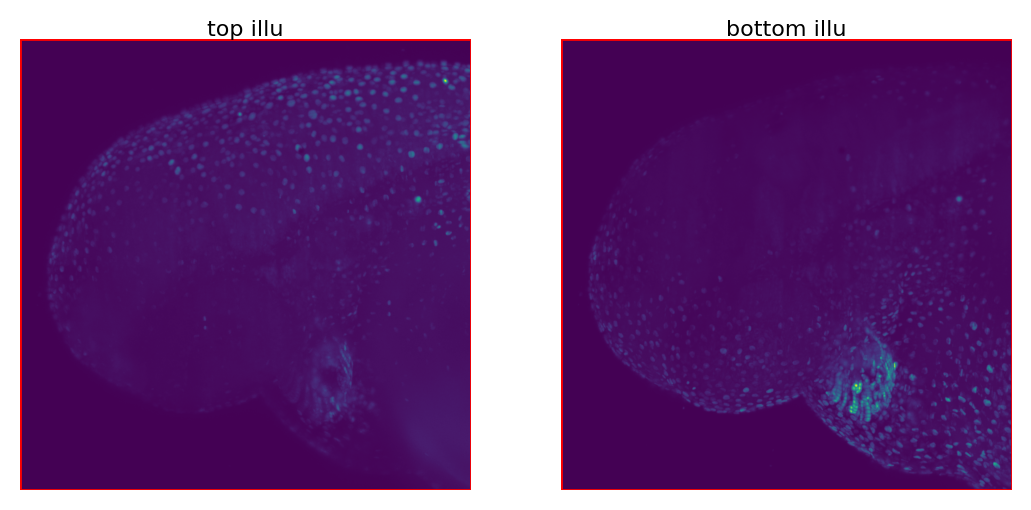


Calculate volumetric measurements...
top/left view: minimum intensity = 60.0, maximum intensity = 2189.0, OTSU threshold = 148.0
bottom/right view: minimum intensity = 53.0, maximum intensity = 4757.0, OTSU threshold = 151.0

Extract features...


NSCT: 100%|██████████| 250/250 [00:10<00:00, 23.91it/s]



Segment sample...


refine along z: 100%|██████████| 2704/2704 [00:02<00:00, 1280.73it/s]



Dual-illumination fusion...
to GPU...
No.049 iteration EM: maximum changes = 1.0
Stitching...


fusion: 100%|██████████| 250/250 [00:47<00:00,  5.24it/s]


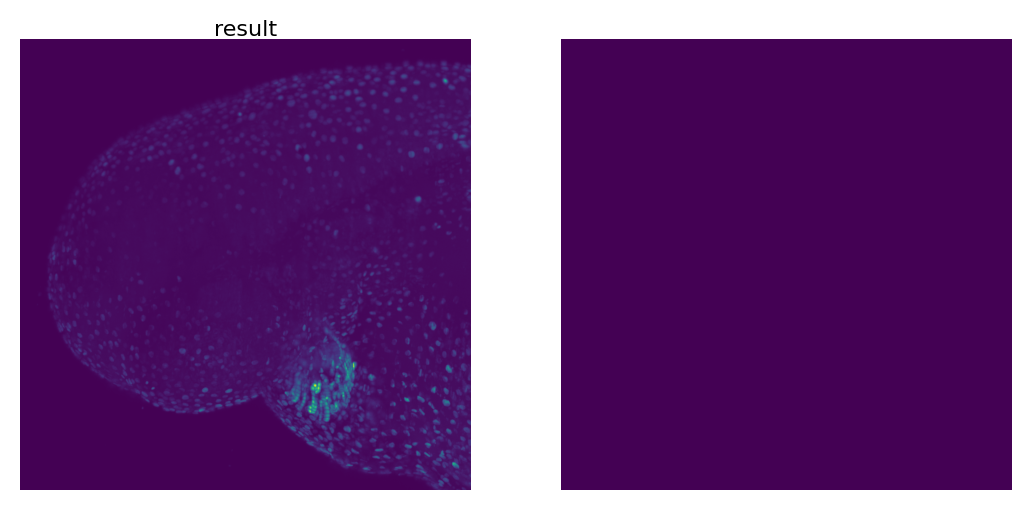

Save...


In [3]:
from leonardo_toolset import FUSE_illu

save_path = "./"
save_folder = "fuse_illu_result"

model = FUSE_illu()
out = model.train(top_illu_data = X_D2_I1,
                  bottom_illu_data = X_D2_I0,
                  save_path = save_path,
                  save_folder = save_folder,
                  save_separate_results = True,
                  )

Step 2: Leonardo-DeStripe

Initialize `DeStripe` in the same way, but when training the model, input the corresponding two slices for X_D2_I1 and X_D2_I0, respectively, instead of the fusion result, togetheer with the corresponding fusion_illu_mask saved under save_path/save_folder/top_illu/fuse_illu_mask. Here, we only use slice 206 for demostration, but of course can also do the same thing for the whole stack:

[Leonardo-DeStripe] Backend: JAX | Device: gpu
Start DeStripe-Fuse...



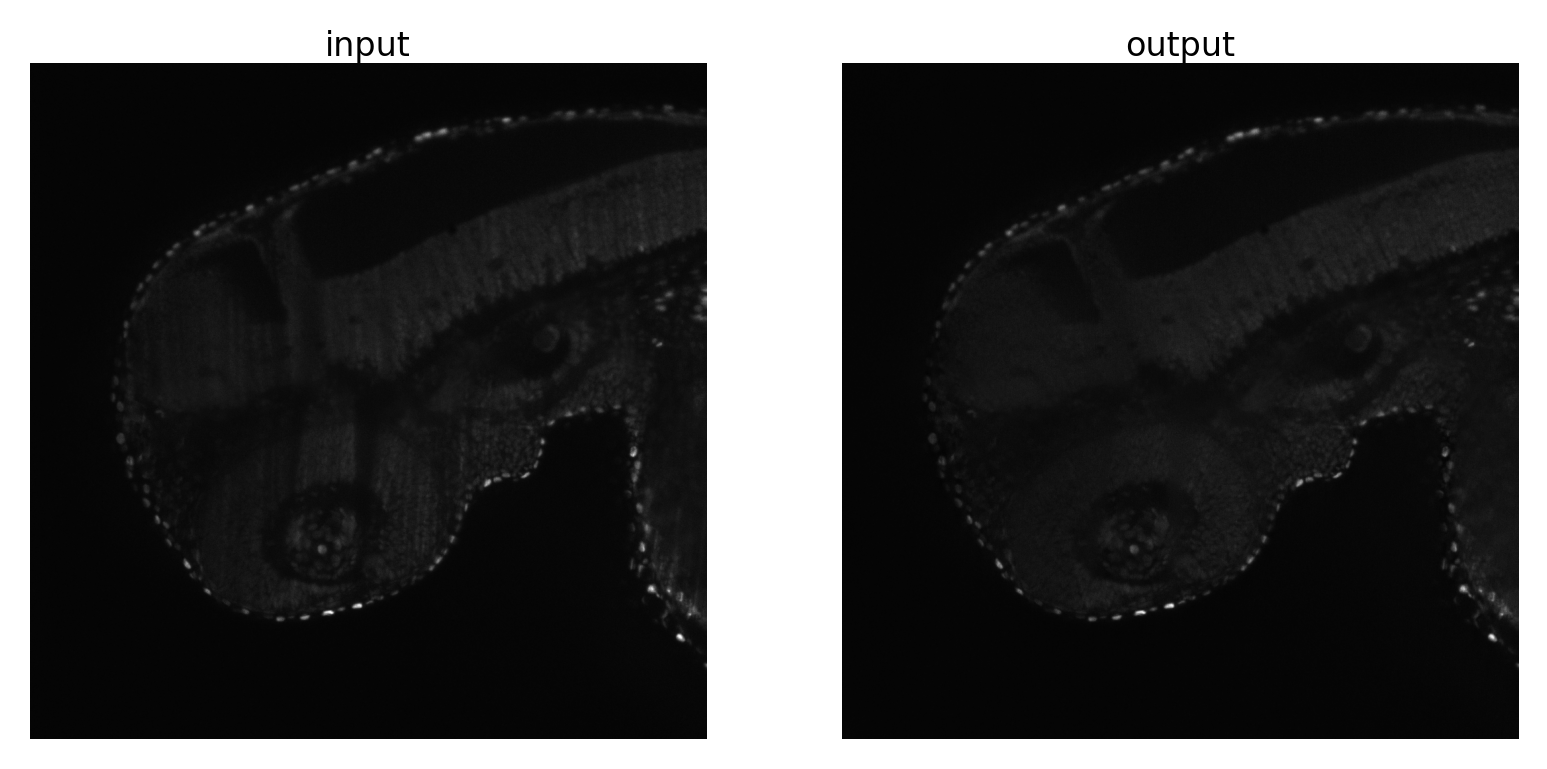

Done


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

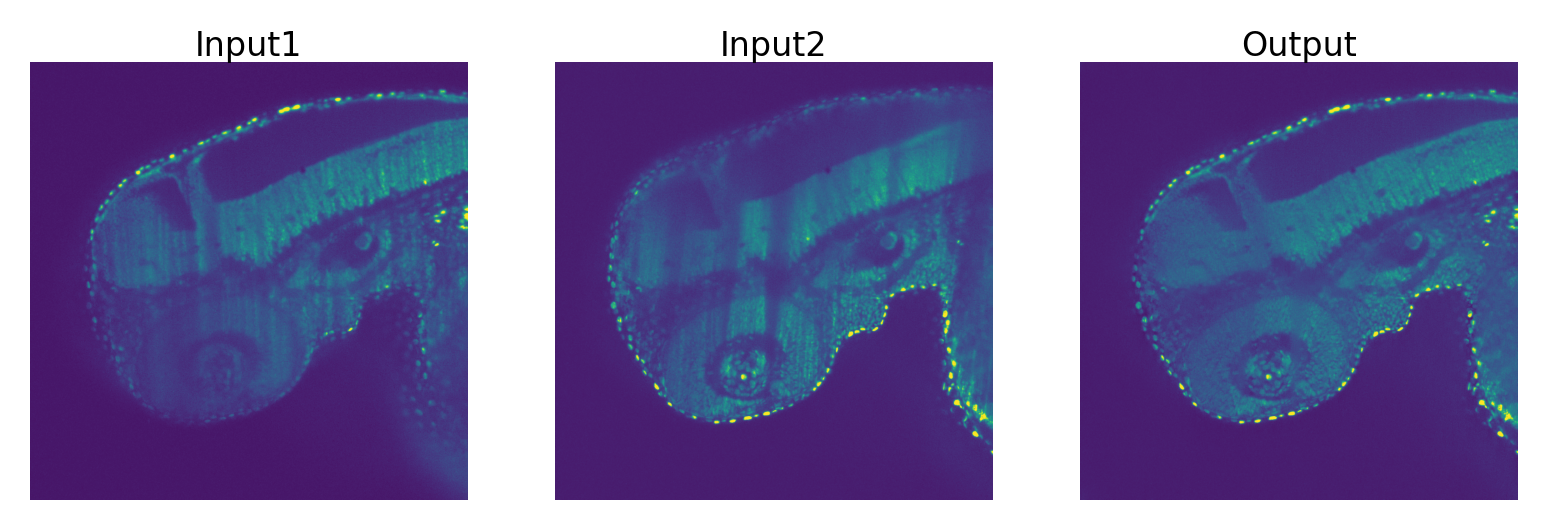

In [4]:
from leonardo_toolset import DeStripe
import numpy as np
import matplotlib.pyplot as plt


model = DeStripe()

recon = model.train(is_vertical = True,
                    display = True,
                    angle_offset_0 = [0],
                    angle_offset_1 = [-3],
                    x_0 = X_D2_I1[206],
                    x_1 = X_D2_I0[206],
                    fusion_mask = np.load("/content/fuse_illu_result/top_illu/fuse_illu_mask/00206.npz")["mask"],
                    )

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=300)
ax1.imshow(X_D2_I1[206], vmax = 500)
ax1.set_title("Input1", fontsize=8, pad=1)
ax1.axis("off")
ax2.imshow(X_D2_I0[206], vmax = 500)
ax2.set_title("Input2", fontsize=8, pad=1)
ax2.axis("off")
ax3.imshow(recon[0], vmax = 500)
ax3.set_title("Output", fontsize=8, pad=1)
ax3.axis("off")

In summary, use `x_0`, `x_1`, instead of `x` for feeding the data-to-be-processed. Correspondinly, use `angle_offset_0` and `angle_offset_1` for indicating stripe orientations. Make sure that `x_0` and `x_1` shoud be consistent with fusion_mask. In this case, `x_0` should be the dataset with illumiation from the top, whereas `x_1` is the stack with illumnation from the bottom.

As discussed under Leonardo-DeStripe section, post-processing for sample structure preservation is also available for Leonardo-DeStripe-Fuse, by simply using `illu_orient_0`, `illu_orient_1`...corresponding to `x_0`, `x_1` and so on:

[Leonardo-DeStripe] Backend: JAX | Device: gpu
Start DeStripe-Fuse...



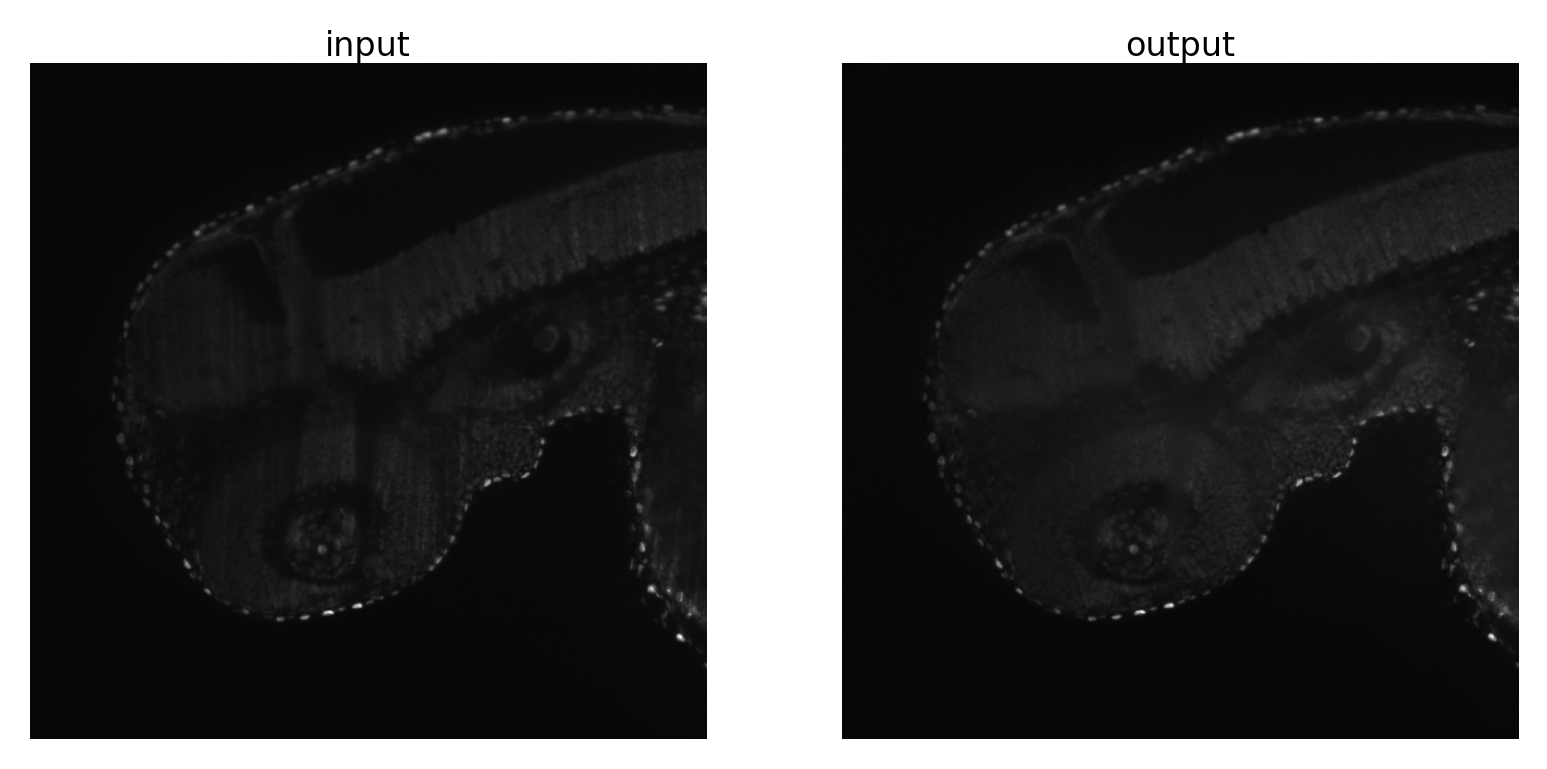

Done


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

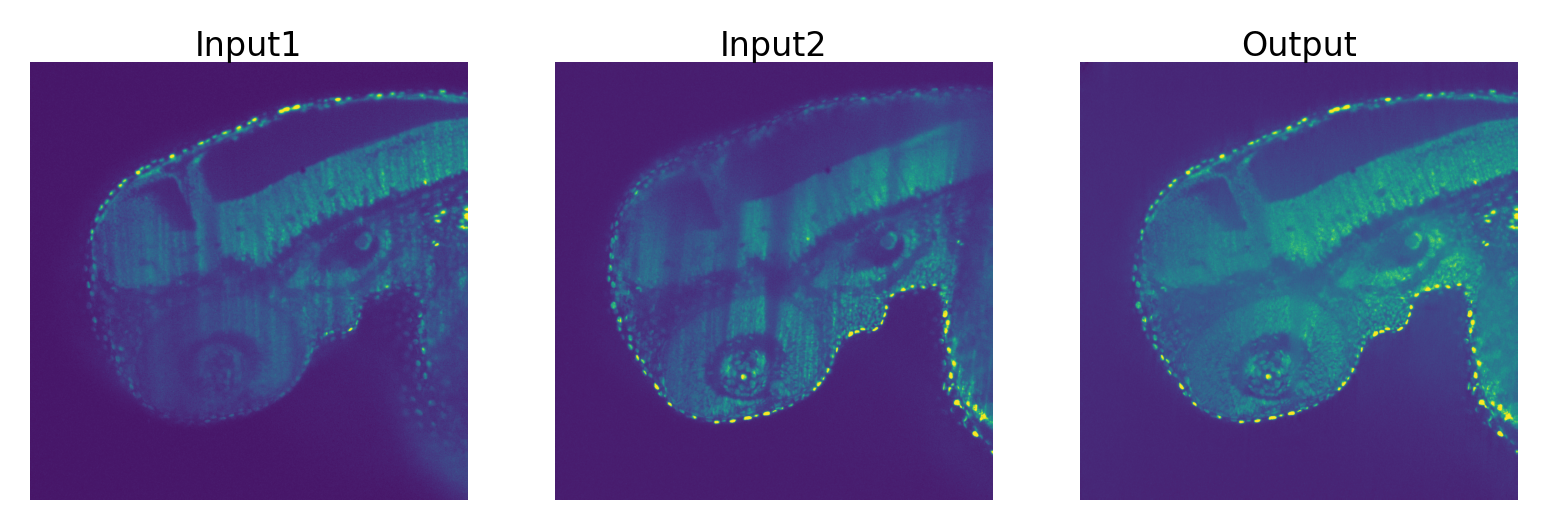

In [5]:
from leonardo_toolset import DeStripe
import numpy as np
import matplotlib.pyplot as plt

model = DeStripe()

recon = model.train(is_vertical = True,
                    display = True,
                    angle_offset_0 = [0],
                    angle_offset_1 = [-3],
                    x_0 = X_D2_I1[206],
                    x_1 = X_D2_I0[206],
                    illu_orient_0 = "top",
                    illu_orient_1 = "bottom",
                    fusion_mask = np.load("/content/fuse_illu_result/top_illu/fuse_illu_mask/00206.npz")["mask"],
                    )

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=300)
ax1.imshow(X_D2_I1[206], vmax = 500)
ax1.set_title("Input1", fontsize=8, pad=1)
ax1.axis("off")
ax2.imshow(X_D2_I0[206], vmax = 500)
ax2.set_title("Input2", fontsize=8, pad=1)
ax2.axis("off")
ax3.imshow(recon[0], vmax = 500)
ax3.set_title("Output", fontsize=8, pad=1)
ax3.axis("off")